In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


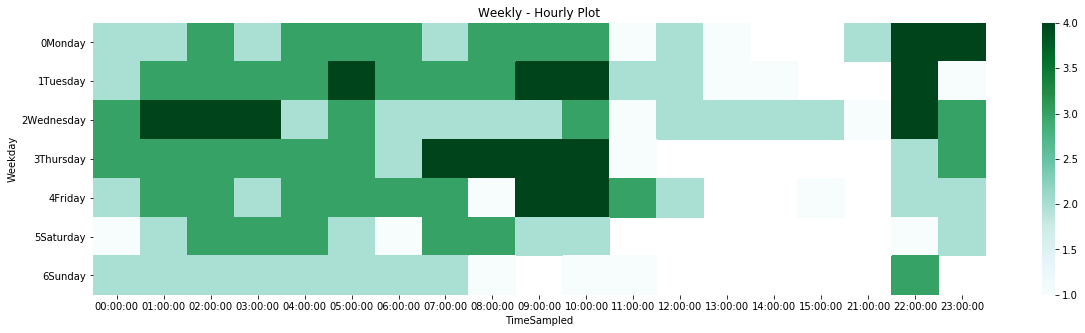

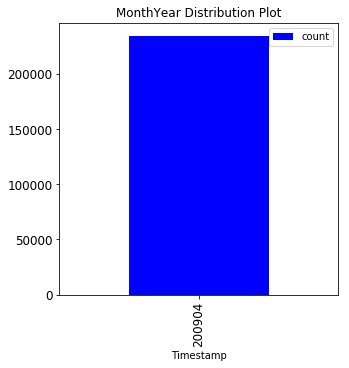

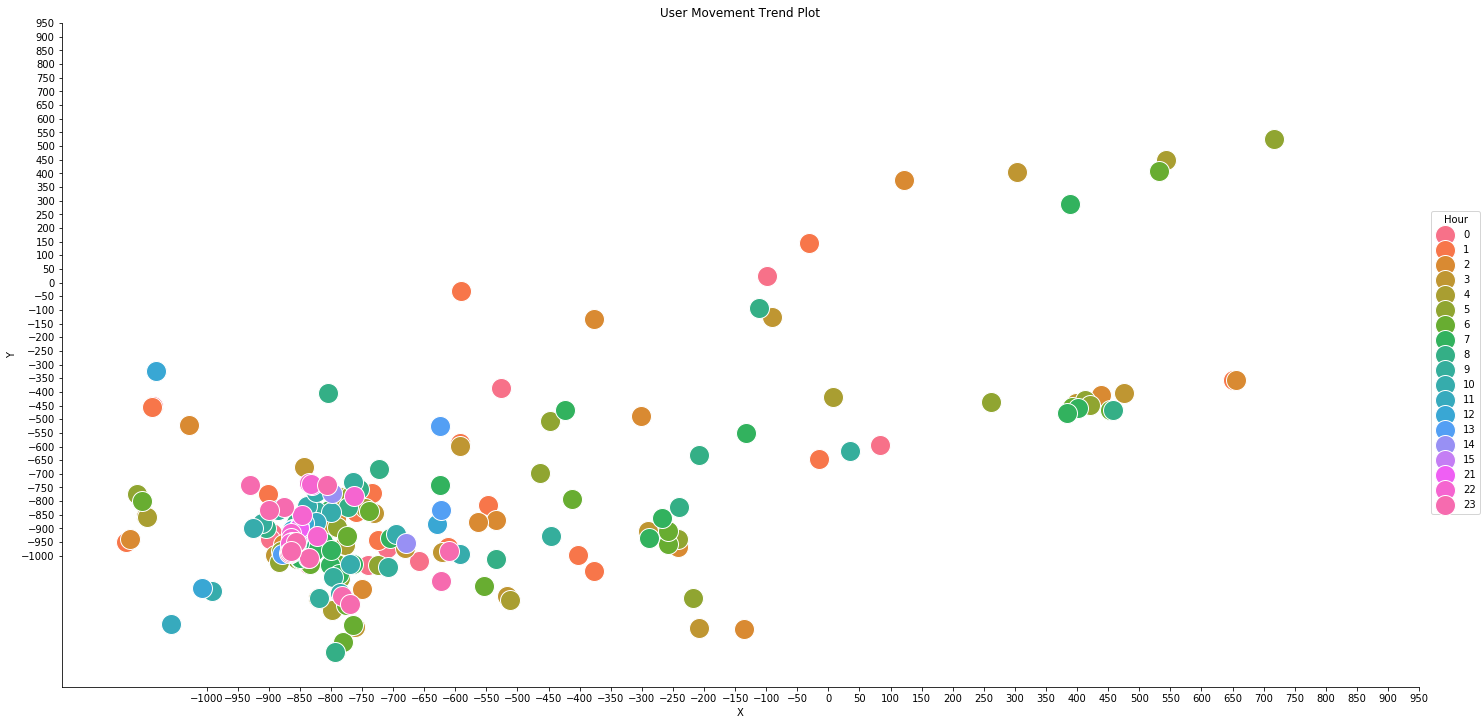

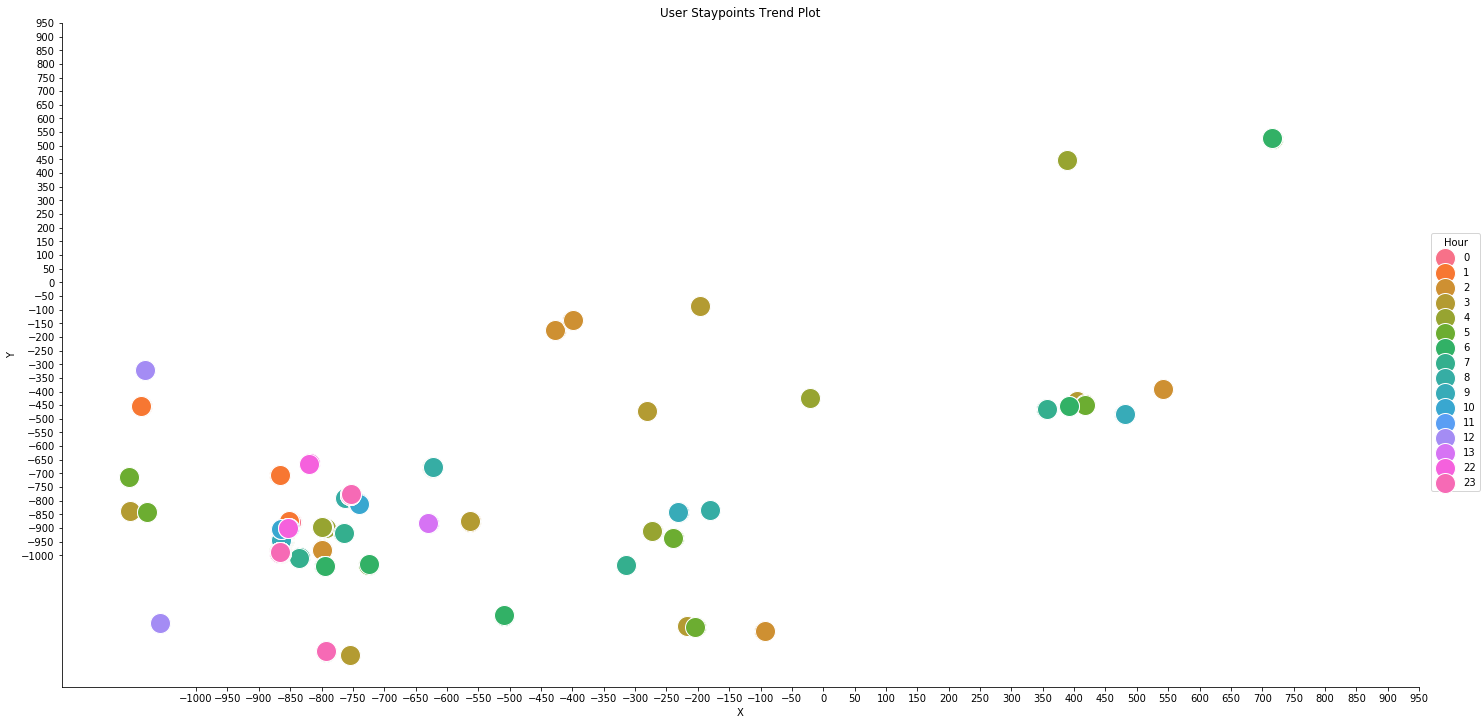

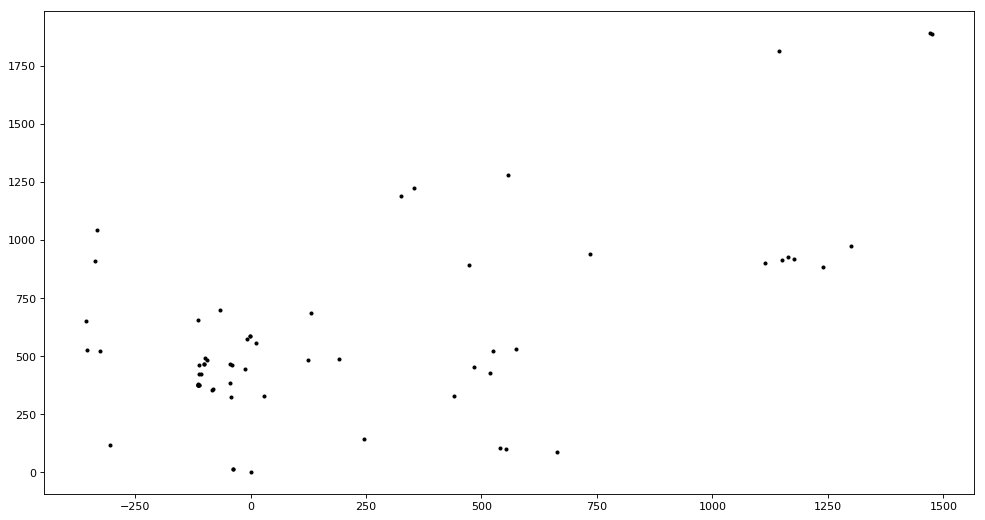

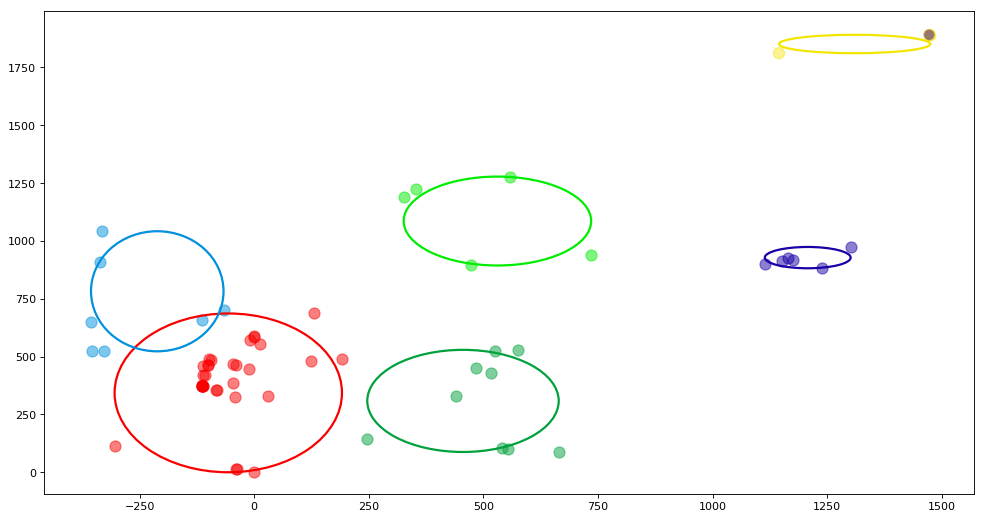

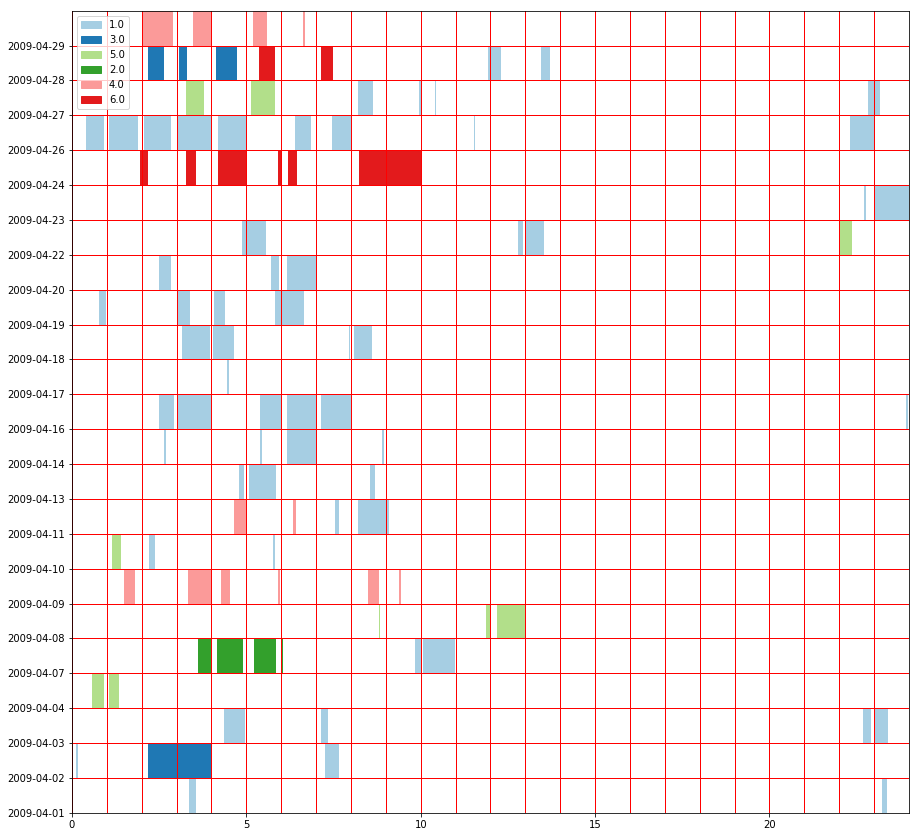

In [6]:
#Finding stay points from a user trajectory data and calculate transition matrices.
#Stay points are goverened by two parameters, time threshold and distance threshold.
#If user has spend more than threshold time(10 mins) at the same geographical location(threshold distance 50m),
# then this location is users stay point.
#This can be users home, work, a bus station or a restaurant. 
%reset

#load all the files for a user
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse, Circle
import operator
import pdb
#%matplotlib nbagg

pd.options.mode.chained_assignment = None

#-----------------------------------LOAD USER FILES-----------------------------------------------------
def load_user_file():
    global combined_df
    #Load file names for user. Change here for different user replace 000 or even path as required
    filenames = glob.glob(file_source_raw)

    #Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

    #put the data from list into one dataframe
    combined_df = pd.concat(list_of_dfs, ignore_index=True)

    #rename columns
    combined_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    combined_df['ClusterId'] = -1
    combined_df['ClusterMeanLat'] = -1
    combined_df['ClusterMeanLon'] = -1
    combined_df['StayPoint'] = -1
    combined_df['DistanceCluster'] = -1

    #add timestamp index
    combined_df["Timestamp"] = combined_df["Date"].map(str) + " " + combined_df["Time"]
    combined_df.Timestamp = pd.to_datetime(combined_df.Timestamp)
    combined_df.index = pd.to_datetime(combined_df.Timestamp)
    
    #add weekday number as column
    combined_df['Weekday'] = combined_df['Timestamp'].dt.weekday.map(str) + combined_df['Timestamp'].dt.weekday_name

    #combined_df.size
    #combined_df.head()

#-----------------------------------SAMPLE DATA PER MINUTE-----------------------------------------------------

def resample_select_data():
    global combined_df
    global sampled_df
    #Resample the data with every one minutes. Remove this if you like to process the entire file.
    #Note, it could take some time to run the further sections of the file size is very large.
    sampled_df = combined_df.resample('1T').mean()
    sampled_df["Timestamp"] = sampled_df.index
    sampled_df = sampled_df.dropna()
    
    #Select the range of data you want to proceed with
    if fltr_data_date_rng == "YES":
        sampled_df = sampled_df[(sampled_df["Timestamp"] >= from_date) & (sampled_df["Timestamp"] <= to_date)]

#-----------------------------------VISUALIZE RAW DATA--------------------------------------------------------

def visualize_raw_data():
    
    if fltr_data_date_rng == "YES":
        combined_c_df = combined_df[(combined_df["Timestamp"] >= from_date) & (combined_df["Timestamp"] <= to_date)]
    else:
        combined_c_df = combined_df
        
    #Plot 1------------------
    #plot hourly vs weekly data of the user
    #Resample data on hourly basis
    hour_sampled_df = combined_c_df.resample('H').last()

    #drop column timestamp to avoid confusion as index is also timestamp
    hour_sampled_df = hour_sampled_df.drop(['Timestamp'], axis=1)

    #extract time from timestamp and add it as a column
    hour_sampled_df['TimeSampled'] = hour_sampled_df.index.time

    #form a pivot table counting number of latitudes for each weekday for each hour
    pivot_df = hour_sampled_df.pivot_table(values='Latitude', index='Weekday',columns='TimeSampled',aggfunc=len)

    #draw a plot to visualize hourly trend per weekday for the user
    fig, ax = plt.subplots(figsize=(20,5))  
    sns.heatmap(pivot_df, cmap='BuGn', ax=ax)
    plt.title('Weekly - Hourly Plot')
    plt.show()
    
    #Plot 2------------------
    #visualize counts of data for each month-year
    count_df = pd.DataFrame()
    count_df['count'] = combined_c_df.groupby(combined_c_df.index.year * 100 + combined_c_df.index.month).size() 
    count_df.plot(kind='bar', title ="V comp",figsize=(5,5),legend=True, fontsize=12, color = 'b')
    plt.title('MonthYear Distribution Plot')
    plt.show()
    
    #Plot 3------------------
    #plot to visualize the location trend of the user
    #Sample data hourly and take mean, drop nans, reset index
    xy_df = combined_c_df.resample('H').mean()
    #xy_df = combined_c_df
    xy_df = xy_df.dropna()
    xy_df['Timestamp'] = xy_df.index
    xy_df = xy_df.reset_index(drop=True)

#     #assign the first lat and log as the base for the plot i.e. origin
#     origin_lat = math.radians(xy_df["Latitude"][0])
#     origin_lon = math.radians(xy_df["Longitude"][0])
    #assign the first lat and log as the base for the plot i.e. origin
    origin_lat = math.radians(combined_df["Latitude"][0])
    origin_lon = math.radians(combined_df["Longitude"][0])
    
    #convert each lat and lon into x and y for the plot w.r.t origin
    EARTH_RAD = 6378100
    xy_df['X'] = 0.0
    xy_df['Y'] = 0.0
    for i in range(0, len(xy_df)):
        x = 0
        y = 0
        current_lat = math.radians(xy_df["Latitude"][i])
        current_lon = math.radians(xy_df["Longitude"][i])
        x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
        y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
        xy_df.at[i, 'X'] = x
        xy_df.at[i, 'Y'] = y
    
    xy_copy_df = xy_df[['X', 'Y', 'Timestamp']].copy()
    xy_copy_df['Hour'] = xy_copy_df.Timestamp.dt.hour
    del xy_copy_df['Timestamp']
    fg = sns.FacetGrid(data=xy_copy_df, hue='Hour',  size = 10, aspect = 2)
    fg.map(plt.scatter, 'X', 'Y', edgecolor="w", s=400).add_legend()
    plt.title('User Movement Trend Plot')
    plt.xlabel('X')
    plt.ylabel('Y')
    xticks = np.arange(-1000,1000,50)
    yticks = np.arange(-1000,1000,50)
    fg.set(xticks=xticks, yticks=yticks)
    plt.show()
    


#-----------------------------------METER DISTANCE BETWEEN TWO COORDINATES---------------------------------------

#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

#This function is to cluster the points together if thier distance is less than 50 meters.
#If the cluster has a total duration of 10 minutes or greater, then add it to a stay point

#-----------------------------------CLUSTER POINTS----------------------------------------------------------

def cluster(newlat, newlon, row, count):
    global sampled_df
    
    currcluster = sampled_df['ClusterId'][row-1]
    sampled_df['ClusterId'][row] = -1
    sampled_df['ClusterMeanLat'][row] = -1
    sampled_df['ClusterMeanLon'][row] = -1
    sampled_df['StayPoint'][row] = -1
    sampled_df['DistanceCluster'][row] = -1
    clulat = sampled_df['ClusterMeanLat'][row-1]
    clulon = sampled_df['ClusterMeanLon'][row-1]
    
    #import pdb; pdb.set_trace()
    if meters(clulat, clulon, newlat, newlon)<= 50:
        sampled_df['ClusterId'][row] = currcluster
        sampled_df['ClusterMeanLat'] = sampled_df.groupby('ClusterId')['Latitude'].transform(np.mean)
        sampled_df['ClusterMeanLon'] = sampled_df.groupby('ClusterId')['Longitude'].transform(np.mean)
        count = count + 1
    else:
        
        if count >= 2:
            #import pdb; pdb.set_trace()
            MinClusTime = sampled_df['Timestamp'][row-count]
            MaxClusTime = sampled_df['Timestamp'][row-1]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            if (l >= 10):
                sampled_df.loc[ (sampled_df['ClusterId']==currcluster), 'StayPoint'] = 1
        count = 1
        sampled_df['ClusterMeanLat'][row] = sampled_df['Latitude'][row]
        sampled_df['ClusterMeanLon'][row] = sampled_df['Longitude'][row]
        sampled_df['ClusterId'][row] = currcluster + 1
    return count

#-----------------------------------FIND STAYPOINTS USING CLUSTERS---------------------------------------------------

def find_stay_points():
    global sampled_df 
    global staypts_df
    
    #Read the file in an online manner as the points come and assign the points to clusters
    row =1
    count = 1
    sampled_df['ClusterId'][row-1] = 0
    sampled_df['ClusterMeanLat'][row-1] = sampled_df['Latitude'][0]
    sampled_df['ClusterMeanLon'][row-1] = sampled_df['Longitude'][0]
    sampled_df['StayPoint'][row-1] = -1
    sampled_df['DistanceCluster'][row-1] = -1
    while row < len(sampled_df):
        #import pdb; pdb.set_trace()
        count = cluster(sampled_df['Latitude'][row], sampled_df['Longitude'][row], row, count)
        row= row + 1

    #copy the stay points into another dataframe
    staypts_df = sampled_df.loc[sampled_df['StayPoint'] == 1]
    
#-----------------------------------GROUP CLUSTERS ON DIFFERENT DAYS-----------------------------------------------

def group_clusters():
    global staypts_df
    
    #this fucntion groups the clusters together from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    staypts_df1 = staypts_df[['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon']].copy()
    staypts_df1 = staypts_df1.drop_duplicates(subset=['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon'])

    staypts_df1 = staypts_df1.sort_values(['ClusterMeanLat', 'ClusterMeanLon'])

    row = 1
    for i in range(0, len(staypts_df1)):
        for j in range(i+1, len(staypts_df1)):
            #import pdb; pdb.set_trace()
        
            chk_cluster = staypts_df1['ClusterId'][i]
            chk_clulat = staypts_df1['ClusterMeanLat'][i]
            chk_clulon = staypts_df1['ClusterMeanLon'][i]
            curr_cluster = staypts_df1['ClusterId'][j]
            curr_clulat = staypts_df1['ClusterMeanLat'][j]
            curr_clulon = staypts_df1['ClusterMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= 50:
                staypts_df.loc[ (staypts_df['ClusterId']==curr_cluster), 'ClusterId'] = chk_cluster
                staypts_df['ClusterMeanLat'] = staypts_df.groupby('ClusterId')['ClusterMeanLat'].transform(np.mean)
                staypts_df['ClusterMeanLon'] = staypts_df.groupby('ClusterId')['ClusterMeanLon'].transform(np.mean)
            else:
                break

#-----------------------------------SAVE STAYPOINTS AS FILE-----------------------------------------------------

def save_file_stay_points():
    #Save the file to a location for further analysis
    staypts_df.to_csv(dest_file_staypoints, sep='\t', encoding='utf-8')

#------------------------------------VISUALIZE STAYPOINTS-------------------------------------------------------

def visualize_stay_points():
    global staypts_df
    #Plot the significant places

#     #load the staypoints file
#     staypts_df = pd.read_csv(dest_file_staypoints, sep='\t')

    #make index as datetime
    staypts_df.index = pd.to_datetime(staypts_df.Timestamp)

    #assign the first lat and log as the base for the plot i.e. origin
    origin_lat = math.radians(combined_df["Latitude"][0])
    origin_lon = math.radians(combined_df["Longitude"][0])
    staypts_df['Timestamp'] = staypts_df.index
    staypts_df = staypts_df.reset_index(drop=True)

    #convert each lat and lon into x and y for the plot w.r.t origin
    EARTH_RAD = 6378100
    staypts_df['X'] = 0.0
    staypts_df['Y'] = 0.0
    for i in range(0, len(staypts_df)):
        x = 0
        y = 0
        current_lat = math.radians(staypts_df["Latitude"][i])
        current_lon = math.radians(staypts_df["Longitude"][i])
        x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
        y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
        staypts_df.at[i, 'X'] = x
        staypts_df.at[i, 'Y'] = y

    #plot the x and y's
    staypts_copy_df = staypts_df[['X', 'Y', 'Timestamp']].copy()
    staypts_copy_df['Hour'] = staypts_copy_df.Timestamp.dt.hour
    del staypts_copy_df['Timestamp']
    #xy_test_df.head()
    fg = sns.FacetGrid(data=staypts_copy_df, hue='Hour',   size = 10, aspect = 2)
    fg.map(plt.scatter, 'X', 'Y', edgecolor="w", s = 400).add_legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("User Staypoints Trend Plot")
    xticks = np.arange(-1000,1000,50)
    yticks = np.arange(-1000,1000,50)
    fg.set(xticks=xticks, yticks=yticks)
    plt.show()
    
    staypts_df.index = pd.to_datetime(staypts_df.Timestamp)
#-----------------------------------CALCULATE HOURLY WEIGHTS FOR STAYPOINTS--------------------------------------
def cal_hourly_cluster_weight():
    global staypts_df
    global cluster_hourly_df    

    for i in range(0, 24):
        cluster_hourly_df['Date'] = 0
        cluster_hourly_df['ClusterId'] = 0
        cluster_hourly_df['DistanceCluster'] = 0
        cluster_hourly_df['AvgLat'] = 0
        cluster_hourly_df['AvgLon'] = 0
        cluster_hourly_df[i] = 0

    last_hour = staypts_df['Timestamp'][0].hour
    last_clusid = staypts_df['ClusterId'][0]
    curr_count = 0
    j = 0
    
    for i in range(0, len(staypts_df)):

        if (i == len(staypts_df)-1):
            
            k = staypts_df['Timestamp'][i] - staypts_df['Timestamp'][i-curr_count+1]
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            date_read = staypts_df.index[i].date()
            cluster_id = staypts_df['ClusterId'][i]
            ClusterMeanLat = staypts_df['ClusterMeanLat'][i]
            ClusterMeanLon = staypts_df['ClusterMeanLon'][i]
            col_name = staypts_df.index[i].hour

            cluster_hourly_df.loc[j,'AvgLat'] = ClusterMeanLat
            cluster_hourly_df.loc[j,'AvgLon'] = ClusterMeanLon
            cluster_hourly_df.loc[j,'Date'] = date_read
            cluster_hourly_df.loc[j,'ClusterId'] = cluster_id
            cluster_hourly_df.loc[j, col_name] = round((l)/60,4)
            
        if (staypts_df['Timestamp'][i].hour != last_hour) | (staypts_df['ClusterId'][i] != last_clusid):
            #import pdb; pdb.set_trace()

            if (curr_count == 1) & (staypts_df['Timestamp'][i].hour != last_hour):
                k = ((staypts_df['Timestamp'][i-1] + pd.Timedelta(hours=1) - 
                      pd.Timedelta(minutes=staypts_df['Timestamp'][i-1].minute)) - 
                     staypts_df['Timestamp'][i-1])
            else:
                k = staypts_df['Timestamp'][i-1] - staypts_df['Timestamp'][i-curr_count]

            l = (k / np.timedelta64(1, 'm')).astype(int)
            date_read = staypts_df.index[i-1].date()
            cluster_id = staypts_df['ClusterId'][i-1]
            ClusterMeanLat = staypts_df['ClusterMeanLat'][i-1]
            ClusterMeanLon = staypts_df['ClusterMeanLon'][i-1]
            col_name = staypts_df.index[i-1].hour

            cluster_hourly_df.loc[j, 'AvgLat'] = ClusterMeanLat
            cluster_hourly_df.loc[j, 'AvgLon'] = ClusterMeanLon
            cluster_hourly_df.loc[j, 'Date'] = date_read
            cluster_hourly_df.loc[j, 'ClusterId'] = cluster_id
            cluster_hourly_df.loc[j, col_name] = round((l)/60,4)
            j = j + 1
            curr_count = 1

            if (staypts_df['Timestamp'][i].hour != last_hour):
                last_hour = staypts_df['Timestamp'][i].hour
            if (staypts_df['ClusterId'][i] != last_clusid):
                last_clusid = staypts_df['ClusterId'][i]
        else:
            curr_count = curr_count + 1

    cluster_hourly_df = cluster_hourly_df.fillna(0)
    cluster_hourly_df = cluster_hourly_df.groupby(['Date', 'ClusterId','DistanceCluster', 'AvgLat', 'AvgLon']).sum()
    cluster_hourly_df = cluster_hourly_df.reset_index(level=[0,1,2,3,4])

#--------------------------------VISUALIZE HOURLY CLUSTER WEIGHT-------------------------------------------------
def visualize_hourly_cluster_weight():
    global staypts_df
    
    #create a color dictionary for each cluster for the plot
    dicts = {}
    clu_list = []
    clu_list = staypts_df['DistanceCluster'].unique()
    #r = lambda: random.randint(0,255)
    colors = sns.color_palette("Paired", len(clu_list))
    
    for i in range(0, len(clu_list)):
        dicts[clu_list[i]] = (colors[i])
        #dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(),r(),r()))
        
    #create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(15,15))
    ax1 = fig2.add_subplot(111, aspect='equal')

    #get all the dates for y axis
    date_list = staypts_df['Timestamp'].dt.date.unique()
    y = range(0, len(date_list))
    def_yticks = date_list
    plt.yticks(y, def_yticks)
    
    #set the x axis limit from 0-24 hours of a day, y axis with dates
    limsx = (0, 24)
    limsy = (0, len(date_list))

    date_counter = 0
    last_date = staypts_df['Timestamp'][0].date()
    last_hour = staypts_df['Timestamp'][0].hour
    last_clusid = staypts_df['DistanceCluster'][0]
    curr_count = 0
    j = 0

    for i in range(0, 24):
        ax1.axvline(x= i, linewidth=1, color='r')

    for i in range(0, len(staypts_df)):
        #import pdb; pdb.set_trace()

        #plot a rectangle if the hour or clusterid or date has changed
        if ((staypts_df['Timestamp'][i].hour != last_hour) | (staypts_df['DistanceCluster'][i] != last_clusid)
           | (last_date != staypts_df['Timestamp'][i].date())):

            if (curr_count == 1) & (staypts_df['Timestamp'][i].hour != last_hour):
                a = staypts_df['Timestamp'][i-curr_count].hour + 1
            else:
                a = staypts_df['Timestamp'][i-curr_count].hour + staypts_df['Timestamp'][i-curr_count].minute/60

            b = staypts_df['Timestamp'][i-1].hour + staypts_df['Timestamp'][i-1].minute/60

            width = b - a
            height = 1
            col_id = dicts.get(staypts_df['DistanceCluster'][i-1])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, color=col_id, label=staypts_df['DistanceCluster'][i-1]))

            curr_count = 1

            if (staypts_df['Timestamp'][i].hour != last_hour):
                last_hour = staypts_df['Timestamp'][i].hour
            if (staypts_df['DistanceCluster'][i] != last_clusid):
                last_clusid = staypts_df['DistanceCluster'][i]
            if (last_date != staypts_df['Timestamp'][i].date()):
                date_counter = date_counter + 1
                last_date = staypts_df['Timestamp'][i].date()
                ax1.axhline(y= date_counter, linewidth=1, color='r')

        else:
            curr_count = curr_count + 1
            
    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)

    plt.xlim(limsx)
    plt.ylim(limsy)
#-----------------------------------SAVE HOURLY CLUSTER FILE-----------------------------------------------------

def save_file_hourly_weights():
    global cluster_hourly_df
    
    #Save the file to a location for further analysis
    cluster_hourly_df.to_csv(dest_file_hourly_weights, sep='\t', encoding='utf-8')

#---------------------------------FIND BEST K FOR K MEAN CLUSTERING -----------------------------------------------
def find_best_k(X):
    MAX_CLUSTERS = len(X)

    # Start clustering number hashes using temporal features
    k_fitted_models = []
    for k in range(1, MAX_CLUSTERS+1):
        if(k > len(X)):
            break
        algo = KMeans(n_clusters = k, init='k-means++', verbose = 0)
        fitted = algo.fit(X)
        k_fitted_models.append(fitted)

    # Compute best k value based the elbow method
    inertias = np.asarray([fitted.inertia_ for fitted in k_fitted_models])
    gradients = -np.diff(np.asarray([fitted.inertia_ for fitted in k_fitted_models]))

    delta_x = inertias[0]/MAX_CLUSTERS

    sum_couples = [(sum(gradients[0:k]), inertias[k]) for k in range(1,len(gradients))]
    atan_couples = [(sum_couples[k][0]/((k+1)*delta_x), sum_couples[k][1]/((len(gradients)-(k+1))*delta_x)) for k in range(len(sum_couples))]
    angle_couples = [(math.atan(atan_couples[k][0])*180/math.pi, math.atan(atan_couples[k][1])*180/math.pi) for k in range(0,len(atan_couples))]
    elbow_angles= [180-(angle_couples[k][0]-angle_couples[k][1]) for k in range(0,len(angle_couples))]

    best_k = min(enumerate(elbow_angles), key=operator.itemgetter(1))[0]+1  # +1 because the first point is not counted in differences such as gradient (+1)
    #import pdb; pdb.set_trace()
    return best_k

#-----------------------------------K-MEAN ON STAY POINTS ---------------------------------------------------------
def k_mean_on_stay_points():
    global staypts_df
    global cluster_hourly_df
    global clus_dict
    
    
    data = cluster_hourly_df[["ClusterId", "AvgLat", "AvgLon"]]
    data = data.drop_duplicates()
    data = data.reset_index(drop=True)
    
    #calculate x and y from Avg Lat and Avg Lon
    #assign the first lat and log as the base for the plot i.e. origin
    origin_lat = math.radians(data["AvgLat"][0])
    origin_lon = math.radians(data["AvgLon"][0])
    
    #convert each lat and lon into x and y 
    EARTH_RAD = 6378100
    data['X'] = 0.0
    data['Y'] = 0.0
    for i in range(0, len(data)):
        x = 0
        y = 0
        current_lat = math.radians(data["AvgLat"][i])
        current_lon = math.radians(data["AvgLon"][i])
        x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
        y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
        data.at[i, 'X'] = x
        data.at[i, 'Y'] = y
    
    #import pdb; pdb.set_trace()
    
    # Plotting lat and log values without clusters
    f1 = data['X'].values
    f2 = data['Y'].values
    X = np.array(list(zip(f1, f2)))
    plt.figure(figsize=(15, 8), dpi=80)
    plt.scatter(f1, f2, c='black', s=7)
    plt.show()
    
    # Best number of clusters
    k = find_best_k(X)
    
    # Number of clusters
    kmeans = KMeans(n_clusters=k)
    # Fitting the input data
    kmeans = kmeans.fit(X)
    # Getting the cluster labels
    labels = kmeans.predict(X)
    # Centroid
    centroids = kmeans.cluster_centers_
    
    #adding the cluster labels as new cluster ids
    data["NewClusterId"] = labels + 1
    
    colors = sns.color_palette("nipy_spectral_r", k)

    fig, ax = plt.subplots(figsize=(15, 8), dpi=80)
    for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
        x2 = max(points[:, 0])
        x1 = min(points[:, 0])
        y2 = max(points[:, 1])
        y1 = min(points[:, 1])
        centre_x = (x2+x1)/2
        centre_y = (y2+y1)/2
        
        ellipse = Ellipse(xy=(centre_x, centre_y), width=(x2-x1), height=(y2-y1), edgecolor=colors[i], fc='None', lw=2)
        ax.add_patch(ellipse)
        #circ = Circle((centre_x, centre_y), rad+5, edgecolor=colors[i], fc='None', lw=2)
        #ax.add_patch(circ)
        ax.scatter(points[:, 0], points[:, 1], s=100, edgecolor=colors[i], alpha=0.5, c = colors[i])

    plt.show()
    
    #create a dictionary for old-new cluster ids
    clus_dict = pd.Series(data.NewClusterId.values,index=data.ClusterId).to_dict()
    
    #update for new cluster ids in all dfs
    for i in range(0, len(cluster_hourly_df)):
        cluster_hourly_df["DistanceCluster"][i] = clus_dict.get(cluster_hourly_df["ClusterId"][i])
    
#     cluster_hourly_df['AvgLat'] = cluster_hourly_df.groupby(['Date', 'ClusterId'])['AvgLat'].transform(np.mean)
#     cluster_hourly_df['AvgLon'] = cluster_hourly_df.groupby(['Date', 'ClusterId'])['AvgLon'].transform(np.mean)
#     cluster_hourly_df = cluster_hourly_df.groupby(['Date', 'ClusterId', 'AvgLat', 'AvgLon']).sum()
#     cluster_hourly_df = cluster_hourly_df.reset_index(level=[0,1,2,3])
    
    for i in range(0, len(staypts_df)):
        staypts_df["DistanceCluster"][i] = clus_dict.get(staypts_df["ClusterId"][i])
#     staypts_df['ClusterMeanLat'] = staypts_df.groupby('ClusterId')['Latitude'].transform(np.mean)
#     staypts_df['ClusterMeanLon'] = staypts_df.groupby('ClusterId')['Longitude'].transform(np.mean)
    
#-----------------------------------CREATE TRANSITION MATRICES-----------------------------------------------------

def create_save_seperate_trasition_matrices():
    #extract unique date list
    date_list = cluster_hourly_df['Date'].unique()
    
    #create a temp dataframe for each data, and calculate trasition matrices from hour t to t+1
    for p in range(0, cluster_hourly_df['Date'].nunique()):
        temp_df = pd.DataFrame()
        matrices_df = pd.DataFrame()
        temp_df = cluster_hourly_df.loc[cluster_hourly_df['Date'] == date_list[p]]
        temp_df = temp_df.reset_index(drop=True)

        for i in range(0, 24):
            matrices_df['Date'] = 0
            matrices_df['ClusterId'] = 0
            for j in range(0, len(temp_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(temp_df['ClusterId'][j])
                matrices_df[colname] = 0

        matrices_df['Date'] = temp_df['Date']
        matrices_df['ClusterId'] = temp_df['ClusterId']
        #import pdb; pdb.set_trace()
        for i in range (0, 23):
            for j in range (0, len(temp_df)):
                for k in range (0, len(temp_df)):
                    prob = temp_df[i][j] * temp_df[i+1][k]
                    colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(temp_df['ClusterId'][k])
                    matrices_df[colname][j] = prob
        file_name = dest_path_each_day_trsn_mat + str(date_list[p]) + ".csv"
        matrices_df.to_csv(file_name, sep='\t', encoding='utf-8')

#---------------------------------------------MARKOV CHAINS-----------------------------------------------------
def create_save_markov_chains():
    global final_transition_df
    
    #create an empty markov chain frame for each clusterid as state, and transition for each hour of the day
    date_list = cluster_hourly_df['Date'].unique()
    cluster_list = cluster_hourly_df['ClusterId'].unique()
    
    for i in range(0, 24):
        final_transition_df['ClusterId'] = 0
        for j in range(0, cluster_hourly_df['ClusterId'].nunique()):
            colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(cluster_list[j])
            final_transition_df[colname] = 0
    final_transition_df['ClusterId'] = cluster_list
    final_transition_df = final_transition_df.fillna(0)
    final_transition_df.index = final_transition_df.ClusterId

    #read each day file and sum the matching rows:cols combinations
    date_list = cluster_hourly_df['Date'].unique()
    path_dir = dest_path_each_day_trsn_mat

    
    for p in range(0, cluster_hourly_df['Date'].nunique()):
        temp_df = pd.DataFrame()
        filename = path_dir + str(date_list[p]) + '.csv'
        temp_df =  pd.read_csv(filename, header = 0, sep='\t')

        for i in range(0, len(temp_df)):
            rowname = temp_df['ClusterId'][i]
            for src_column in temp_df:
                for dest_column in final_transition_df:
                    if src_column == dest_column and src_column != 'ClusterId' :
                        #import pdb; pdb.set_trace()
                        final_transition_df[dest_column][rowname] = (final_transition_df[dest_column][rowname] +
                                                                    temp_df[src_column][i])

    #calculate probability from cluster x to cluster y from time t to t+1
    final_transition_df = final_transition_df.reset_index(drop=True)
    for clus in range(0, len(final_transition_df)):
        for i in range(0, 24):
            temp_sum = 0
            for j in range(0, len(final_transition_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(final_transition_df['ClusterId'][j])
                temp_sum += (final_transition_df[colname][clus])
            for k in range(0, len(final_transition_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(final_transition_df['ClusterId'][k])
                if temp_sum != 0:
                    final_transition_df[colname][clus] = final_transition_df[colname][clus]/temp_sum

    
    #replace zero probabilities to a small value and save the file
    final_transition_df = final_transition_df.fillna(0)                    
    final_transition_df = final_transition_df.replace(0, 0.00001)
    final_transition_df.to_csv(dest_file_final_markov_chain, sep='\t')
    
    for i in range(0, 24):
        final_transition_temp_df = pd.DataFrame()
        k = cluster_hourly_df['ClusterId'].nunique()*i + 1
        final_transition_temp_df = final_transition_df.iloc[:,k:k + cluster_hourly_df['ClusterId'].nunique()]
        final_transition_temp_df.index = cluster_list
        file_name = usr_markov_chains_directory + "/" + str(i) + " hour.csv"
        final_transition_temp_df.to_csv(file_name, sep='\t', encoding='utf-8')

#---------------------------------------------- S  T  A  R  T  -------------------------------------------------
#Start of the program
                                                                                                                                                                                                                                                                                                                                                                                                        
#global dataframes used
combined_df = pd.DataFrame()
sampled_df = pd.DataFrame()
staypts_df = pd.DataFrame()
cluster_hourly_df = pd.DataFrame()
final_transition_df = pd.DataFrame()
clus_dict = {}

#source, destination path and filter till date(till when the data needs to be considered). Change according to your needs
from_date = "2009-04-01 00:00:00"
to_date = "2009-04-30 00:00:00"
fltr_data_date_rng = "YES"
user = "041"


usr_directory = "/home/shashank/Documents/location/Data/User " + user
usr_hrly_wght_directory = "/home/shashank/Documents/location/Data/User " + user + "/hourlyweights"
usr_sty_pts_directory = "/home/shashank/Documents/location/Data/User " + user + "/staypoints"
usr_markov_chains_directory = "/home/shashank/Documents/location/Data/User " + user + "/markovchains"

if not os.path.exists(usr_directory):
    os.makedirs(usr_directory)
if not os.path.exists(usr_hrly_wght_directory):
    os.makedirs(usr_hrly_wght_directory)
if not os.path.exists(usr_sty_pts_directory):
    os.makedirs(usr_sty_pts_directory)  
if not os.path.exists(usr_markov_chains_directory):
    os.makedirs(usr_markov_chains_directory)  

    
file_source_raw = "/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/" + user + "/Trajectory/200*.plt" 
dest_file_staypoints = usr_sty_pts_directory + "/" + from_date + "-" + to_date + ".csv"
dest_file_hourly_weights = usr_hrly_wght_directory + "/" + from_date + "-" + to_date + ".csv"
dest_path_each_day_trsn_mat = usr_hrly_wght_directory + "/"
dest_file_final_markov_chain = usr_markov_chains_directory + "/final.csv"

load_user_file()

resample_select_data()

if sampled_df.empty:
    print('No data to be processed. Change user or date range and try again.')
else:
    visualize_raw_data()

    find_stay_points()
    if not staypts_df.empty:
        
        group_clusters()

        visualize_stay_points()

        cal_hourly_cluster_weight()

        k_mean_on_stay_points()

        visualize_hourly_cluster_weight()

        save_file_stay_points()

        save_file_hourly_weights()

        create_save_seperate_trasition_matrices()

        create_save_markov_chains()